# IIT 4.0 demonstration

PyPhi is a software toolbox that provides the reference implementation of Integrated Information Theory (IIT).

This notebook is to be used with the [`feature/iit-4.0` branch of PyPhi](https://github.com/wmayner/pyphi/tree/feature/iit-4.0). It is meant to accompany the IIT 4.0 paper, [available here](https://doi.org/10.48550/arXiv.2212.14787).

## Installing PyPhi

First, we use `pip` to install PyPhi and its dependencies:

In [ ]:
!python -m pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0

In [ ]:
import pyphi
import math
import numpy as np

pyphi.config.PROGRESS_BARS = False
pyphi.config.PARALLEL = False
pyphi.config.SHORTCIRCUIT_SIA = False

## Loading system data

The first part of the tutorial will be based on the second system from Figure 8C of the IIT 4.0 paper:
_"Functionally equivalent networks with different Φ-structures"_.

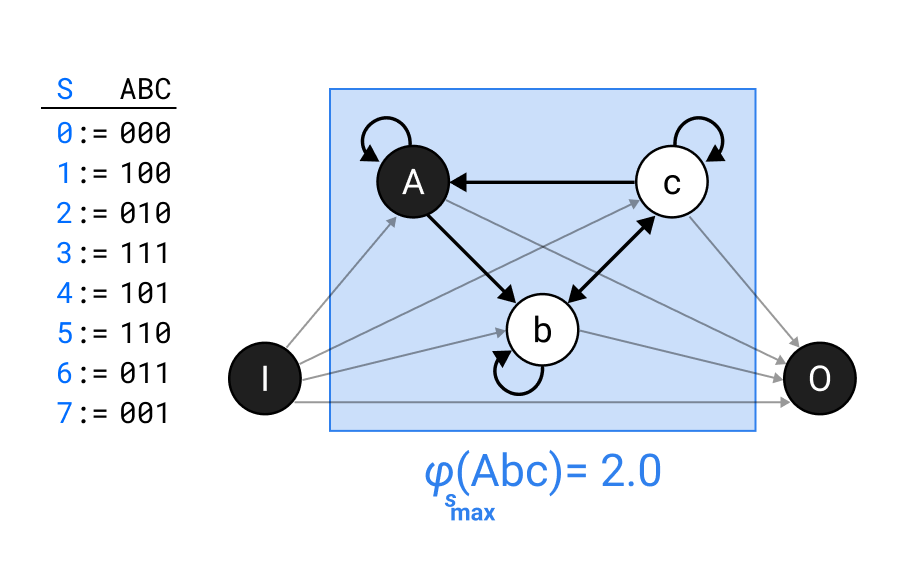

Background conditions (nodes "I" and "O") have already been fixed to
"I"=ON, "O"=ON in the hypothetical 5-node Transition Probability Matrix (TPM).
Therefore, we will start from a TPM which only contains nodes "A", "B", "C".

In [ ]:
import pyphi
import numpy as np

node_labels = ("A", "B", "C")

# TPM in state-by-node format (see `help(pyphi.Network)` for information on TPM
# representations).
tpm = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 1],
        [0, 0, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
    ]
)

# The network's adjacency matrix. In its absence, PyPhi will assume all-to-all
# connectivity. PyPhi uses the "from-to" convention: a "1" in entry (i,j) means
# there is a directed edge from unit i to unit j, and a "0" means there is not.
# NOTE: If the adjacency matrix indicates a connection between units when there
# is no causal connection according to the TPM, the analysis will correctly
# determine that; however, if the matrix specifies the *lack* of a connection,
# the analysis will assume no causal influence even if the TPM implies that
# there is.
connectivity_matrix = np.array([
    [1, 1, 0,],  # A->A, A->B
    [0, 1, 1,],  # B->B, B->C
    [1, 1, 1,],  # C->A, C->B, C->C
])

We begin by instantiating a `Network` object. This represents the "universal"
physical substrate, which serves as the operational starting point to assess the
causal powers and intrinsic properties of a system within it.

In [ ]:
network = pyphi.Network(tpm, cm=connectivity_matrix, node_labels=node_labels)
network

Network(ExplicitTPM([[[[1. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [0. 0. 1.]]]


 [[[0. 1. 0.]
   [1. 1. 0.]]

  [[0. 1. 1.]
   [1. 0. 1.]]]]), cm=[[1 1 0]
 [0 1 1]
 [1 1 1]])

Now we instantiate a `Subsystem` object. All further analysis of the resulting
`candidate_system` will be performed for a `state` of interest.  Here we use the
full network "Abc".  In general, system nodes that are excluded from the keyword
argument `nodes` act as fixed background units to the analysis, which means that
the TPM is conditioned on their respective state as specified by `state`.

In [ ]:
# A=ON, B=OFF, C=OFF (Abc in Figure 7).
state = (1, 0, 0)

candidate_system = pyphi.Subsystem(network, state, nodes=node_labels)
candidate_system

Subsystem(A, B, C)

## System Irreducibility Analysis: identifying complexes

From the System Irreducibility Analysis (SIA), we can see that the
`candidate_system` in state `(1, 0, 0)` exists (it has both cause and effect power, since $\textrm{ii}_c > 0$ and $\textrm{ii}_e > 0$) in a way that is intrinsic (within the system
Abc), informative (it picks out specific previous and next states), and
integrated ($φ_s$ > 0 for the minimum partition).

In [ ]:
sia = pyphi.new_big_phi.sia(candidate_system)
sia

┌───────────────────────────────────┐
│ SystemIrreducibilityAnalysis      │
│  ━━━━━━━━━━━━━━━━━━━━━━━━━        │
│       Subsystem:  A,B,C           │
│   Current state:  (1,0,0)         │
│             φ_s: 2.0              │
│  Normalized φ_s: 0.4              │
│           CAUSE:  (0,0,0)         │
│            II_c: 3.0              │
│          EFFECT:  (0,1,0)         │
│            II_e: 3.0              │
│    #(tied MIPs): 2                │
│       Partition:                  │
│                  3 parts: {A,B,C} │
│                  [[0 0 1]         │
│                   [1 0 1]         │
│                   [1 1 0]]        │
└───────────────────────────────────┘

Two tied minimum partitions (MIPs) were found, one of which cuts the
`candidate_system` into three parts. The 1s in the partition matrix
indicate connections that are severed. Note that system partitions are directed,
so the matrix may be asymmetric.

In [ ]:
sia.partition

3 parts: {A,B,C}
[[0 0 1]
 [1 0 1]
 [1 1 0]]

We can access properties which hold the corresponding system integrated
information ($φ_s$, its irreducibility), and a normalized
system integrated information ($φ_s$ divided by the maximum $φ_s$ that
could be obtained for a system of three nodes).

In [ ]:
print(f"φ_s = {sia.phi}")
print(f"φ_s_norm = {sia.normalized_phi}")

φ_s = 2.0
φ_s_norm = 0.4


By the principle of minimal existence, $φ_s$ must be the minimum between the $φ$
of the maximally irreducible cause and the maximally irreducible effect within
the `candidate_system` itself. For this particular `candidate_system` at the
current particular `state`, it turns out cause and effect are equally
irreducible.

In [ ]:
print(sia.cause.phi)
print(sia.effect.phi)

2.0
2.0


### Maximal cause-effect state

Let's look more closely at one of them:

In [ ]:
sia.effect

┌─────────────────────────────────────────────────┐
│         RepertoireIrreducibilityAnalysis        │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│                      φ: 2.0                     │
│           Normalized φ:  None                   │
│              Mechanism:  [A,B,C]                │
│                Purview:  [A,B,C]                │
│        Specified state:  ┌───────────────────┐  │
│                       :  │  Specified EFFECT │  │
│                       :  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│                       :  │ EFFECT:  (0,1,0)  │  │
│                       :  │   II_e: 3.0       │  │
│                       :  └───────────────────┘  │
│            Selectivity: 1.0                     │
│             Forward Pr: 1                       │
│ Partitioned forward Pr: 0.25                    │
│              Partition:  3 parts: {A,B,C}       │
│                       :  [[0 0 1]               │
│                       :   [1 0 1]               │
│           

Recall that $φ_s$ is evaluated for a specific cause or effect state, which is
defined as the state that maximizes intrinsic information ($\textrm{ii}$). We can
inspect this state:

In [ ]:
sia.effect.specified_state

┌───────────────────┐
│  Specified EFFECT │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (0,1,0)  │
│   II_e: 3.0       │
└───────────────────┘

Let's go deeper into PyPhi's API to recompute the specified effect state:

In [ ]:
maximal_effect_state = candidate_system.intrinsic_information(
    direction=pyphi.Direction.EFFECT,
    mechanism=candidate_system.node_indices,
    purview=candidate_system.node_indices,
)

# NOTE: You can use also
# `pyphi.new_big_phi.system_intrinsic_information(candidate_system)`
# to obtain both cause and effect states at once.

maximal_effect_state

┌───────────────────┐
│  Specified EFFECT │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (0,1,0)  │
│   II_e: 3.0       │
└───────────────────┘

### System integrated information ($φ_s$)

Let's use PyPhi to recompute `sia.effect` and $φ_s$. We will use the fact
that we already know the MIP to avoid going through all partitions.

In [ ]:
# NOTE: the full set of system partitions may be manually computed by invoking:
system_partitions = pyphi.partition.system_partitions(
    candidate_system.node_indices, node_labels=candidate_system.node_labels
)

cut_candidate_system = candidate_system.apply_cut(sia.partition)

maximal_effect_state = pyphi.new_big_phi.system_intrinsic_information(candidate_system)

We can now compute the integration value with respect to a direction,
`candidate_system`, `cut_candidate_system` and the `maximal_effect_state` we
had already obtained.

In [ ]:
pyphi.new_big_phi.integration_value(
    pyphi.Direction.EFFECT, candidate_system, cut_candidate_system, maximal_effect_state
)

┌─────────────────────────────────────────────────┐
│         RepertoireIrreducibilityAnalysis        │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│                      φ: 2.0                     │
│           Normalized φ:  None                   │
│              Mechanism:  [A,B,C]                │
│                Purview:  [A,B,C]                │
│        Specified state:  ┌───────────────────┐  │
│                       :  │  Specified EFFECT │  │
│                       :  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│                       :  │ EFFECT:  (0,1,0)  │  │
│                       :  │   II_e: 3.0       │  │
│                       :  └───────────────────┘  │
│            Selectivity: 1.0                     │
│             Forward Pr: 1                       │
│ Partitioned forward Pr: 0.25                    │
│              Partition:  3 parts: {A,B,C}       │
│                       :  [[0 0 1]               │
│                       :   [1 0 1]               │
│           

### Exclusion: identifying the first complex

We know the `candidate_system` is irreducible. But is it maximally
irreducible? We will go through all its subsets, computing system
irreducibility analyses for all of them.

Indeed, in this case the full `candidate_subsystem` Abc
wins over all its subsets (note that in general, the largest subset is not necessarily the maximally irreducible one).

In [ ]:
for sia in pyphi.new_big_phi.all_complexes(network, state):
    node_labels = candidate_system.node_labels.coerce_to_labels(sia.node_indices)
    print(f"φ_s = {sia.phi} {node_labels}")

# PyPhi's API includes a function for finding the maximal complex:
pyphi.new_big_phi.maximal_complex(network, candidate_system.state)

φ_s = 2.0 ('A', 'B', 'C')
φ_s = 0.0 ('A', 'C')
φ_s = 0.0 ('A', 'B')
φ_s = 0.0 ('C',)
φ_s = 1.0 ('A',)


┌───────────────────────────────────┐
│ SystemIrreducibilityAnalysis      │
│  ━━━━━━━━━━━━━━━━━━━━━━━━━        │
│       Subsystem:  A,B,C           │
│   Current state:  (1,0,0)         │
│             φ_s: 2.0              │
│  Normalized φ_s: 0.4              │
│           CAUSE:  (0,0,0)         │
│            II_c: 3.0              │
│          EFFECT:  (0,1,0)         │
│            II_e: 3.0              │
│    #(tied MIPs): 2                │
│       Partition:                  │
│                  3 parts: {A,B,C} │
│                  [[0 0 1]         │
│                   [1 0 1]         │
│                   [1 1 0]]        │
└───────────────────────────────────┘

## Distinctions

Now that the maximal complex or physical substrate of consciousness has been
identified, we can "unfold" the substrate to examine the compositional structure of the distinctions it specifies and the relations among them.

Note: We will keep referring to it as the `candidate_subsystem`.

For example, does mechanism "A" specify an irreducible distinction? Yes, it does:

In [ ]:
mechanism = (0,)

# NOTE: Mechanism partitions are represented as fractions, with mechanism parts
# in the numerator and purview parts in the denominator.

candidate_system.concept(mechanism)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                  Concept: mechanism = [A], state = [1]
         φ = 0.4387218755409                            
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ┌───────────────────────────────────────────────┐ ┌───────────────────────────────────────────────────────────┐
 │          Maximally-irreducible cause          │ │                Maximally-irreducible effect               │
 │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │ │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
 │                      φ: 0.5                   │ │                      φ: 0.43872187554086717               │
 │           Normalized φ: 0.25                  │ │           Normalized φ: 0.43872187554086717               │
 │              Mechanism:  [A]                  │ │              Mechanism:  [A]               

Does the higher-order mechanism "Ab" specify an irreducible distinction? It does:

In [ ]:
mechanism = (0, 1)
candidate_system.concept(mechanism)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        Concept: mechanism = [A,B], state = [1, 0]
           φ = 0.4150374992788                     
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ┌────────────────────────────────────────────────┐ ┌────────────────────────────────────────────────┐
 │          Maximally-irreducible cause           │ │          Maximally-irreducible effect          │
 │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │ │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
 │                      φ: 0.5                    │ │                      φ: 0.41503749927884376    │
 │           Normalized φ: 0.125                  │ │           Normalized φ: 0.41503749927884376    │
 │              Mechanism:  [A,B]                 │ │              Mechanism:  [A,B]                 │
 │                Purview:  [A,B,C]               │ │                Purv

What about mechanism "Ac"? This mechanism does not specify a
distinction, because it is
reducible on the cause side:

In [ ]:
mechanism = (0, 2)
candidate_system.concept(mechanism)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        Concept: mechanism = [A,C], state = [1, 0]
                  φ = 0                           
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ┌───────────────────────────────────────────────┐ ┌────────────────────────────────────────────────┐
 │          Maximally-irreducible cause          │ │          Maximally-irreducible effect          │
 │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │ │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
 │                      φ: 0.0                   │ │                      φ: 1.4150374992788437     │
 │           Normalized φ: 0.0                   │ │           Normalized φ: 0.4716791664262812     │
 │              Mechanism:  [A,C]                │ │              Mechanism:  [A,C]                 │
 │                Purview:  [B,C]                │ │                Purview:  [A,B

Notice that PyPhi picks a particular cause purview even though all purviews are reducible. You may restrict the search to a subset of purviews to convince
yourself that they are in fact reducible:

In [ ]:
mechanism = (0, 2)

cause_purviews = (
    c
    for c in pyphi.utils.powerset(candidate_system.node_indices)
    if c not in ((), (1, 2))
)

candidate_system.concept(mechanism, cause_purviews=cause_purviews)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        Concept: mechanism = [A,C], state = [1, 0]
                  φ = 0                            
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ┌────────────────────────────────────────────────┐ ┌────────────────────────────────────────────────┐
 │          Maximally-irreducible cause           │ │          Maximally-irreducible effect          │
 │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │ │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
 │                      φ: 0.0                    │ │                      φ: 1.4150374992788437     │
 │           Normalized φ: 0.0                    │ │           Normalized φ: 0.4716791664262812     │
 │              Mechanism:  [A,C]                 │ │              Mechanism:  [A,C]                 │
 │                Purview:  [A,B,C]               │ │                Purv

The `Subsystem` methods `candidate_system.mic()` and `candidate_system.mie()`
are useful if you are only interested in finding a maximally-irreducible cause
or effect. For example:

In [ ]:
mechanism = (0, 2)
candidate_system.mic(mechanism)

┌───────────────────────────────────────────────┐
│          Maximally-irreducible cause          │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│                      φ: 0.0                   │
│           Normalized φ: 0.0                   │
│              Mechanism:  [A,C]                │
│                Purview:  [B,C]                │
│        Specified state:  ┌─────────────────┐  │
│                       :  │ Specified CAUSE │  │
│                       :  │  ╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│                       :  │  CAUSE:  (0,0)  │  │
│                       :  │   II_c: 0.5     │  │
│                       :  └─────────────────┘  │
│            Selectivity: 0.5                   │
│             Forward Pr: 0.5                   │
│ Partitioned forward Pr: 0.5                   │
│              Partition:   A     C     ∅       │
│                       :  ─── ✕ ─── ✕ ───      │
│                       :   ∅    B,C    ∅       │
│             State ties: 1                     │


## Relations

Causal relations capture how the causes and/or effects of a set of distinctions overlap with each other.

We can obtain all 4 irreducible distinctions (mechanisms "A", "b", "c", "Ab"),
and then use them to find causal relations among them.

In [ ]:
distinctions = pyphi.compute.ces(candidate_system)

**NOTE:** Before computing relations, it is important to filter out distinctions that are incongruent with the state specified by the entire candidate system (this is done automatically by the `phi_structure()` function, discussed below).

In [ ]:
distinctions = distinctions.resolve_congruence(sia.system_state)

Now we can compute all relations among these distinctions:

In [ ]:
relations = pyphi.relations.relations(distinctions)
relations

═════════════════════════════════════
          ConcreteRelations          
═════════════════════════════════════
        Σφ_r: 1.850501040044065
#(relations): 9                
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.20751874963942188 │  
  │  Purview:  [b, B]             │  
  │ #(faces): 2                   │  
  └───────────────────────────────┘  
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.10375937481971094 │  
  │  Purview:  [b]                │  
  │ #(faces): 1                   │  
  └───────────────────────────────┘  
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.20751874963942188 │  
  │  Purview:  [a, c]             │  
  │ #(faces): 2                   │  
  └───────────────────────────────┘  
  ┌─────────────────────

The output functions like a `set` object containing all the relations. Each relation in turn also functions like a `set` that contains the distinctions that are related. Additionally, relations have

 - A `relation.phi` value.
 - `relation.faces`: A set of relation faces, each corresponding to an overlap among the purviews of some causes and effefcts
 - `relation.purview`: The union of the face purviews (or, equivalently, the intersection of the distinction cause/effect purview unions).

Let's examine the relation between the first two distinctions.

In [ ]:
relation = pyphi.relations.relation(distinctions[:2])
relation

┌──────────────────────────────┐
│           Relation           │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│      φ_r: 0.2924812503605781 │
│  Purview:  [a, c]            │
│ #(faces): 2                  │
└──────────────────────────────┘

We can look at the relation's faces:

In [ ]:
relation.faces

frozenset({┌──────────────────────────┐
           │       RelationFace       │
           │ ━━━━━━━━━━━━━━━━━━━━━━━━ │
           │ Purview:  [a]            │
           │  Relata: 2               │
           │           Cause[0]/[0,2] │
           │           Cause[1]/[0,1] │
           └──────────────────────────┘,
           ┌───────────────────────────┐
           │        RelationFace       │
           │ ━━━━━━━━━━━━━━━━━━━━━━━━━ │
           │ Purview:  [c]             │
           │  Relata: 2                │
           │           Effect[1]/[2]   │
           │            Cause[0]/[0,2] │
           └───────────────────────────┘})

As with collections of relations and relations themselves, a relation face also functions like a `set`. It contains the causes/effects which have a nonempty congruent overlap among their purviews.

This congruent overlap is stored in the `purview` attribute:

In [ ]:
face = next(iter(relation.faces))
face.purview

{a}

## Cause-effect structure and big Φ

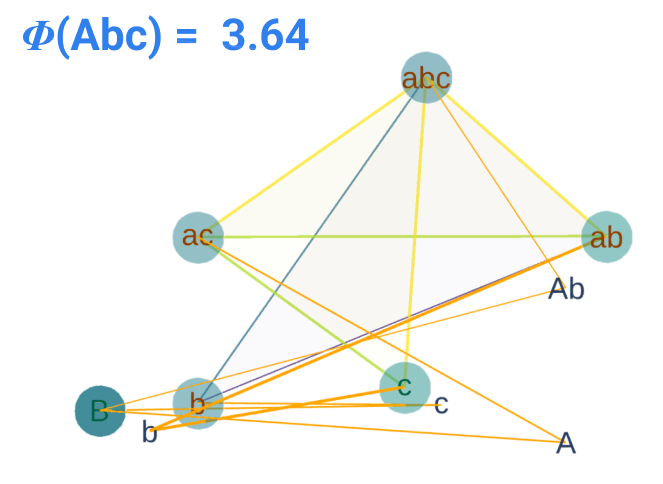


For convenience, PyPhi can be asked to fully unfold the cause-effect
structure of a `candidate_system`, which performs all the method calls
described above. If the `candidate_system` is in turn a maximal complex (as
found in the [System Irreducibility Analysis](#scrollTo=95b5fc3f)), then the cause-effect structure
is called a Φ-structure.

In [ ]:
phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
phi_structure

┌───────────────────────────────────────┐
│              PhiStructure             │
│   ══════════════════════════════════  │
│                 Φ: 3.642982290404643  │
│   #(distinctions): 4                  │
│             Σ φ_d: 1.792481250360578  │
│      #(relations): 9                  │
│             Σ φ_r: 1.850501040044065  │
│ ┌───────────────────────────────────┐ │
│ │ SystemIrreducibilityAnalysis      │ │
│ │  ━━━━━━━━━━━━━━━━━━━━━━━━━        │ │
│ │       Subsystem:  A,B,C           │ │
│ │   Current state:  (1,0,0)         │ │
│ │             φ_s: 2.0              │ │
│ │  Normalized φ_s: 0.4              │ │
│ │           CAUSE:  (0,0,0)         │ │
│ │            II_c: 3.0              │ │
│ │          EFFECT:  (0,1,0)         │ │
│ │            II_e: 3.0              │ │
│ │    #(tied MIPs): 2                │ │
│ │       Partition:                  │ │
│ │                  3 parts: {A,B,C} │ │
│ │                  [[0 0 1]         │ │
│ │                   [1 0 1]     

Individual properties and components of the structure remain accessible:

In [ ]:
# φ_s
print(f"φ_s = {phi_structure.sia.phi}")
# Big Φ (sum of distinctions and relations' small φ)
print(f"  Φ = {phi_structure.big_phi}")

φ_s = 2.0
  Φ = 3.642982290404643


In [ ]:
phi_structure.distinctions

════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
                                       CauseEffectStructure (4 distinctions)                                        
════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
                                                Concept: mechanism = [A], state = [1]                               
                                       φ = 0.4387218755409                                                          
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
   ┌───────────────────────────────────────────────┐ ┌───────────────────────────────────────────────────────────┐  
   │          Maximally-irreducible cause          │ │          

In [ ]:
phi_structure.relations

═════════════════════════════════════
          ConcreteRelations          
═════════════════════════════════════
        Σφ_r: 1.850501040044065
#(relations): 9                
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.20751874963942188 │  
  │  Purview:  [b, B]             │  
  │ #(faces): 2                   │  
  └───────────────────────────────┘  
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.10375937481971094 │  
  │  Purview:  [b]                │  
  │ #(faces): 1                   │  
  └───────────────────────────────┘  
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.20751874963942188 │  
  │  Purview:  [a, c]             │  
  │ #(faces): 2                   │  
  └───────────────────────────────┘  
  ┌─────────────────────

# Reproducing figures 1, 2 and 4

This is the network used in Figure 1, Figure 2 and Figure 4 in the main IIT 4.0 text, analyzed using PyPhi to reproduce the results shown there.

We start by defining the substrate and the state of interest:

In [ ]:
k = 4

weights = np.array(
    [
        [-.2, 0.7, 0.2],
        [0.7, -.2, 0.0],
        [0.0, -.8, 0.2]
    ]
)

node_labels = ["A", "B", "C"]

network = pyphi.network_generator.build_network(
    [pyphi.network_generator.ising.probability] * len(weights),
    weights,
    temperature=1 / k,
)

state = (0, 1, 1)

## Figure 1: Identifying complexes

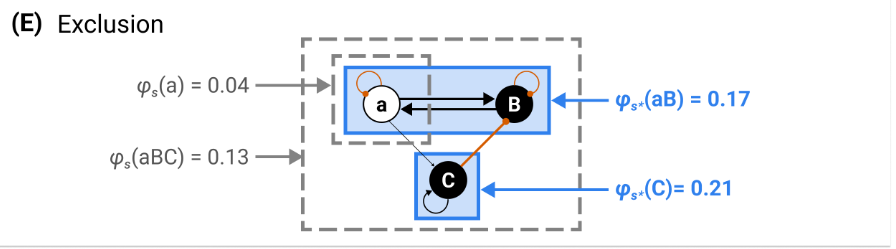

Let's jump straight into panel (E) in Fig 1, by performing a combinatorial search over all possible candidate subsystems, applying exclusion to find the _first maximally-irreducible complex_, then repeating the procedure with the remaining units to find the _second maximally-irreducible complex_ and so on.

As shown in Fig 1, the substrate aBC condenses into complexes C and aB:

In [ ]:
# System Irreducibility Analyses
sias = sorted(
    list(pyphi.backwards.all_combined_complexes(network, state)), reverse=True
)

sias

[┌─────────────────────────────────────┐
 │     SystemIrreducibilityAnalysis    │
 │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
 │      Subsystem:  C                  │
 │  Current state:  (1)                │
 │            φ_s: 0.21221955291860525 │
 │ Normalized φ_s: 0.21221955291860525 │
 │          CAUSE:  (1)                │
 │           II_c: 0.21221955291860525 │
 │         EFFECT:  (1)                │
 │           II_e: 0.291059849766587   │
 │   #(tied MIPs): 0                   │
 │      Partition:                     │
 │                 Complete            │
 │                 [[1]]               │
 └─────────────────────────────────────┘,
 ┌────────────────────────────────────┐
 │    SystemIrreducibilityAnalysis    │
 │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
 │      Subsystem:  A,B               │
 │  Current state:  (0,1)             │
 │            φ_s: 0.1718628889918048 │
 │ Normalized φ_s: 0.1718628889918048 │
 │          CAUSE:  (1,0)             │
 │           II_c: 0.84

## Figure 2: Distinctions

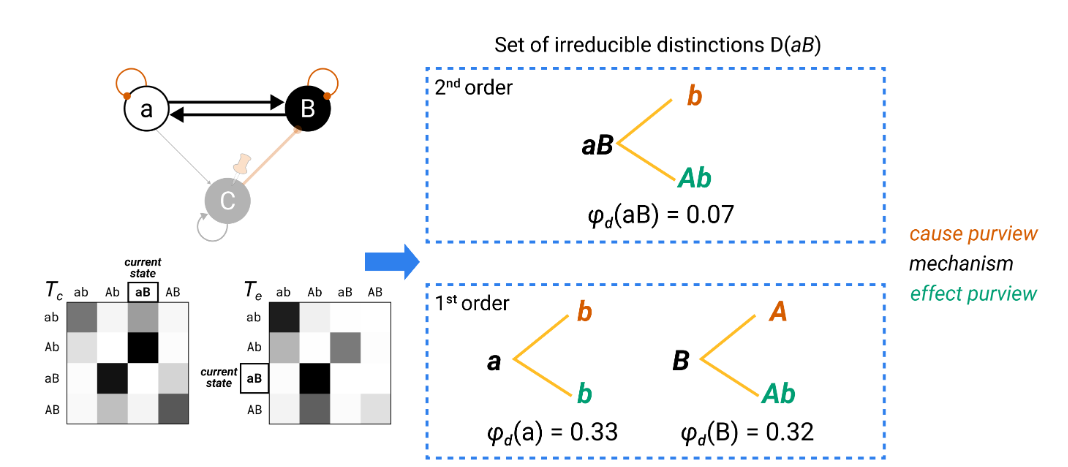

We now want to derive all the irreducible distinctions in complex aB, both first-order and higher-order together with their $φ_d$ values. Intermediate steps are also included (intrinsic information, MIP).

In [ ]:
# Select the System Irreducibility Analysis corresponding to complex aC:
sia = sias[1]
nodes = sia.node_indices  # Same as nodes = (0, 1)

# Obtain backward and forward subsystems.
subsystem_backward = pyphi.Subsystem(network, state, nodes, backward_tpm=True)
subsystem_forward = pyphi.Subsystem(network, state, nodes)

# Unfold all the irreducible distinctions in complex aC.
distinctions = pyphi.backwards.compute_combined_ces(
    subsystem_backward, subsystem_forward
)

# Discard potential distinctions which are incongruent with the cause and
# effect specified by the complex as a whole.
distinctions = distinctions.resolve_congruence(sia.system_state)

print(distinctions)

══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
                                            CauseEffectStructure (3 distinctions)                                             
══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
                                                        Concept: mechanism = [A], state = [0]                                 
                                         φ = 0.3327283938209                                                                  
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
   ┌─────────────────────────────────────────────────────────┐ ┌───────────────────────────────────────────────

### A more detailed derivation

In [ ]:
# Change this to explore different mechanisms.
mechanism = (0,)

#### Intrinsic information ($\textrm{ii}$) and the specified cause/effect state.

In [ ]:
DIRECTION = pyphi.Direction.CAUSE
SUBSYSTEM = subsystem_backward

# Explore all cause purviews.
purviews = SUBSYSTEM.potential_purviews(DIRECTION, mechanism)

for purview in purviews:
    # Find specified state for this particular purview: the state for which
    # intrinsic information is maximum.
    specified_states = SUBSYSTEM.intrinsic_information(
        DIRECTION, mechanism, purview
    ).ties

    print(specified_states)

[┌────────────────────────────┐
│      Specified CAUSE       │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ CAUSE:  (1)                │
│  II_c: 0.06980285397331121 │
└────────────────────────────┘]
[┌───────────────────────────┐
│      Specified CAUSE      │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ CAUSE:  (0)               │
│  II_c: 0.8258578730383902 │
└───────────────────────────┘]
[┌────────────────────────────┐
│      Specified CAUSE       │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ CAUSE:  (1,0)              │
│  II_c: 0.46777326104702377 │
└────────────────────────────┘]


Similarly for the effect side:

In [ ]:
DIRECTION = pyphi.Direction.EFFECT
SUBSYSTEM = subsystem_forward

# Explore all effect purviews.
purviews = SUBSYSTEM.potential_purviews(DIRECTION, mechanism)

for purview in purviews:
    # Find specified state for this particular purview: the state for which
    # intrinsic information is maximum.
    specified_states = SUBSYSTEM.intrinsic_information(
        DIRECTION, mechanism, purview
    ).ties

    print(specified_states)

[┌────────────────────────────┐
│      Specified EFFECT      │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (1,0)             │
│   II_e: 0.2326278989028132 │
└────────────────────────────┘]
[┌─────────────────────────────┐
│       Specified EFFECT      │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (0)                │
│   II_e: 0.33272839382093894 │
└─────────────────────────────┘]
[┌────────────────────────────┐
│      Specified EFFECT      │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (1)               │
│   II_e: 0.0698028539733112 │
└────────────────────────────┘]


#### Minimum partition (MIP) and integrated information ($\varphi$)

In [ ]:
DIRECTION = pyphi.Direction.CAUSE
SUBSYSTEM = subsystem_backward

# Explore all cause purviews.
purviews = SUBSYSTEM.potential_purviews(DIRECTION, mechanism)

cause_mips = []

for purview in purviews:
    # Explore all mechanism partitions for this particular purview and find MIP:
    # the partition for which integrated information is minimum.

    # NOTE: this call internally recomputes and uses the specified state.
    mip = SUBSYSTEM.find_mip(DIRECTION, mechanism, purview)

    print(mip)
    cause_mips.append(mip)

┌──────────────────────────────────────────────────────────┐
│             RepertoireIrreducibilityAnalysis             │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│                      φ: 0.06980285397331104              │
│           Normalized φ: 0.06980285397331104              │
│              Mechanism:  [A]                             │
│                Purview:  [A]                             │
│        Specified state:  ┌────────────────────────────┐  │
│                       :  │      Specified CAUSE       │  │
│                       :  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│                       :  │ CAUSE:  (1)                │  │
│                       :  │  II_c: 0.06980285397331121 │  │
│                       :  └────────────────────────────┘  │
│            Selectivity: 0.5463029642226259               │
│             Forward Pr: 0.5463029642226259               │
│ Partitioned forward Pr: 0.5000000000000001               │
│              Partition

Similarly for the effect side:

In [ ]:
DIRECTION = pyphi.Direction.EFFECT
SUBSYSTEM = subsystem_forward

# Explore all effect purviews.
purviews = SUBSYSTEM.potential_purviews(DIRECTION, mechanism)

effect_mips = []

for purview in purviews:
    # Explore all mechanism partitions for this particular purview and find MIP:
    # the partition for which integrated information is minimum.

    # NOTE: this call internally recomputes and uses the specified state.
    mip = SUBSYSTEM.find_mip(DIRECTION, mechanism, purview)

    print(mip)
    effect_mips.append(mip)

┌──────────────────────────────────────────────────────────┐
│             RepertoireIrreducibilityAnalysis             │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│                      φ: 0.251343053043136                │
│           Normalized φ: 0.125671526521568                │
│              Mechanism:  [A]                             │
│                Purview:  [A,B]                           │
│        Specified state:  ┌────────────────────────────┐  │
│                       :  │      Specified EFFECT      │  │
│                       :  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│                       :  │ EFFECT:  (1,0)             │  │
│                       :  │   II_e: 0.2326278989028132 │  │
│                       :  └────────────────────────────┘  │
│            Selectivity: 0.5445004826806572               │
│             Forward Pr: 0.5445004826806572               │
│ Partitioned forward Pr: 0.3954047860567819               │
│              Partition

#### Maximal cause/effect purviews and $φ_d$

Finally, select the maximal cause and maximal effect purviews for this mechanism. Remember the distinction's irreducibility ($φ_d$) will be the
minimum of the two.

In [ ]:
# Find maximal cause and effect.
print(max(cause_mips))
print(max(effect_mips))

┌─────────────────────────────────────────────────────────┐
│             RepertoireIrreducibilityAnalysis            │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│                      φ: 0.8258578730383899              │
│           Normalized φ: 0.8258578730383899              │
│              Mechanism:  [A]                            │
│                Purview:  [B]                            │
│        Specified state:  ┌───────────────────────────┐  │
│                       :  │      Specified CAUSE      │  │
│                       :  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │  │
│                       :  │ CAUSE:  (0)               │  │
│                       :  │  II_c: 0.8258578730383902 │  │
│                       :  └───────────────────────────┘  │
│            Selectivity: 0.9271000422005082              │
│             Forward Pr: 0.9271000422005082              │
│ Partitioned forward Pr: 0.5000000000000001              │
│              Partition:   A     ∅     

## Figure 4: Relations

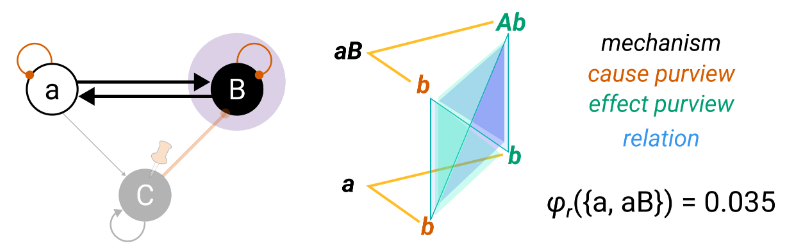

It turns out that all $2^{3} - 1$ relations among distinctions a, B and AB exist.

As in Fig 4, we will focus on the first-order relation {a, aB}, with overlap over purview _b_ and $φ_r$ = 0.035

In [ ]:
relations = pyphi.relations.relations(distinctions)
print(f"Total number of relations: {len(relations)}\n")

# Filter out relations other than the one between {aB, a}
a_aB_relation = [
    relation for relation in relations if (relation.mechanisms == {(0, 1), (0,)})
]

print(a_aB_relation)

Total number of relations: 7

[┌───────────────────────────────┐
│            Relation           │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│      φ_r: 0.03572021119668863 │
│  Purview:  [b]                │
│ #(faces): 9                   │
└───────────────────────────────┘]


### A more detailed derivation

#### Computing a specific relation

We start by selecting the relevant distinctions:

In [ ]:
# Assuming a certain order, we can slice the object with all distinctions to
# only include first (a) and third (aB) ones.
distinctions_a_aB = distinctions[::2]
distinctions_a_aB

══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
                                            CauseEffectStructure (2 distinctions)                                             
══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
                                                        Concept: mechanism = [A], state = [0]                                 
                                         φ = 0.3327283938209                                                                  
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
   ┌─────────────────────────────────────────────────────────┐ ┌───────────────────────────────────────────────

From the relevant distinctions, PyPhi then computes the combinations of size
greater than 2 that share a congruent purview overlap.

Since we are dealing with only two distinctions, there's only one such combination of distinctions: the pair {a, aB} itself.

In [ ]:
combinations = pyphi.relations._combinations_with_nonempty_congruent_overlap(
    distinctions_a_aB,
    min_degree=2,
    max_degree=None
)

combinations

setset([set([0, 1])])

We are ready to reconstruct the relation by calling `pyphi.relations.Relation`:

In [ ]:
for combination in combinations:
  relation = pyphi.relations.Relation((distinctions_a_aB[i] for i in combination))
  print(relation)

┌───────────────────────────────┐
│            Relation           │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│      φ_r: 0.03572021119668863 │
│  Purview:  [b]                │
│ #(faces): 9                   │
└───────────────────────────────┘


#### Computing $φ_r$

Then, the relation's irreducibility value ($φ_r$) is defined as the $φ_d$-per-unit ratio for the distinction (relatum) with the minumum such value  (`distinction_phi_per_unique_purview_unit`), weighted by the size of the overlap (`len(relation.purview)`):

In [ ]:
distinction_phi_per_unique_purview_unit = [
    relatum.phi / len(relatum.purview_union) for relatum in relation
]

phi_r = len(relation.purview) * min(distinction_phi_per_unique_purview_unit)
print(f"φ_r = {phi_r}")

φ_r = 0.03572021119668863


# PyPhi documentation

See [pyphi.readthedocs.io](https://pyphi.readthedocs.io/en/latest/) for further information on PyPhi usage and its API.